# SETUP

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy, re
from wordcloud import WordCloud

# Fonctions

In [175]:
def remove_emojis(input_text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251" 
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', input_text)

def supprimer_espaces_inutiles(chaine):
    # Utiliser une expression régulière pour remplacer les espaces multiples par un seul espace
    chaine_sans_espaces_inutiles = re.sub(r'\s+', ' ', chaine)
    return chaine_sans_espaces_inutiles.strip()  # Supprimer les espaces au début et à la fin de la chaîne

# Créer une fonction pour nettoyer le texte
def clean_text(text):
    # Supprimer les espaces blancs
    text = text.strip()
    # Supprimer les retours à la ligne
    text = text.replace('\n', ' ')
    # Supprimer les espaces inutiles
    text = supprimer_espaces_inutiles(text)
    # Supprimer les caractères spéciaux
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    # Supprimer les emojis
    text = remove_emojis(text)
    return text


# Traite du csv

In [184]:
nlp = spacy.load("en_core_web_sm")

# Load csv file
df = pd.read_csv('sample_data/Restaurant_reviews.csv', sep=',', encoding='utf-8')

# delete columns that are not needed
df.drop(['Reviewer', 'Metadata', 'Time', 'Pictures','7514'], axis=1, inplace=True)

# delete rows where restaurant, rating, and review are missing
df.dropna(subset=['Restaurant', 'Rating', 'Review'], inplace=True)

# Appliquer la fonction de nettoyage au texte
df['Review'] = df['Review'].apply(clean_text)

# Conversion de la colonne Rating en type entier
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

conditions = [
    (df['Rating'].isin([1, 2])),  # Conditions pour les notes 1 et 2
    (df['Rating'] == 3),           # Condition pour la note 3
    (df['Rating'].isin([4, 5]))    # Conditions pour les notes 4 et 5
]

values = [0, 1, 2]  # Valeurs correspondantes pour chaque condition

df['Label'] = np.select(conditions, values)  # Créer une nouvelle colonne Label avec les valeurs correspondantes
df['Label'] = df['Label'].astype(int)  # Convertir la colonne Label en type entier

# affichage du nombre de labels
print(df['Label'].value_counts())

Label
2    6199
0    2564
1    1192
Name: count, dtype: int64


# Création du csv trains et test

In [185]:
# Create a new CSV file with cleaned data
df.to_csv('sample_data/reviews_test.csv', index=False)
print(df['Label'].value_counts())

Label
2    6199
0    2564
1    1192
Name: count, dtype: int64


In [186]:
# Create a new CSV with equal number of positive, negative and neutral reviews
df_negative = df[df['Label'] == 0].sample(1000) # 1000 negative reviews
df_neutral = df[df['Label'] == 1].sample(1000) # 1000 neutral reviews
df_positive = df[df['Label'] == 2].sample(1000) # 1000 positive reviews

df_balanced = pd.concat([df_positive, df_negative, df_neutral])

df_balanced.to_csv('sample_data/reviews_trains.csv', index=False)
print(df_balanced['Label'].value_counts())

Label
2    1000
0    1000
1    1000
Name: count, dtype: int64


In [187]:
csv_train = 'sample_data/reviews_trains.csv'

# Load csv file
df_train = pd.read_csv(csv_train, sep=',', encoding='utf-8')

nlp_data = pd.DataFrame({'text': df_train['Review'], "label": df_train['Label']}) 

nlp_data

,text,label
0,Raza has treated us very well Good choice of m...,2
1,Yesterday I was here with my two friends it wa...,2
2,I chose Veg Kurkure Momo s from this place aft...,2
3,The place is spacious ambience is pretty good ...,2
4,Food was good,2
...,...,...
2995,Been here twice We have ordered Biryani s Ther...,1
2996,Just your normal cafe nothing out of the ordin...,1
2997,The drinks were good the food was mediocre the...,1
2998,Over the moon Name is not matching with ambien...,1


In [188]:
print("Check for missing values in Train dataset")
null_check=nlp_data.isnull().sum()
print(null_check)

Check for missing values in Train dataset
text     0
label    0
dtype: int64


In [191]:
for i in range(2):
    print(df_positive)

                     Restaurant  \
6905             The Indi Grill   
3800            The Glass Onion   
8540              Momos Delight   
7860                 Khaan Saab   
2093                   13 Dhaba   
...                         ...   
5815                   Tempteys   
3768        Kritunga Restaurant   
7959               Olive Garden   
1516                        KFC   
1447  AB's - Absolute Barbecues   

                                                 Review  Rating  Label  
6905  Raza has treated us very well Good choice of m...     5.0      2  
3800  Yesterday I was here with my two friends it wa...     5.0      2  
8540  I chose Veg Kurkure Momo s from this place aft...     4.0      2  
7860  The place is spacious ambience is pretty good ...     4.0      2  
2093                                      Food was good     4.0      2  
...                                                 ...     ...    ...  
5815  Very smooth delivery and timing Happy with the...     5.0     

In [192]:
for i in range(2):
    print(df_neutral)

                                   Restaurant  \
4719                          Shanghai Chef 2   
860                               Hyper Local   
9186  Cascade - Radisson Hyderabad Hitec City   
4547                              Owm Nom Nom   
601                                   eat.fit   
...                                       ...   
5204                        Biryanis And More   
7609            The Old Madras Baking Company   
1380            The Lal Street - Bar Exchange   
442                Over The Moon Brew Company   
8685                       The Chocolate Room   

                                                 Review  Rating  Label  
4719  Ambiance Shanghai Chef has one of it s outlet ...     3.0      1  
860   They have this amazing IPL offer 600 for 4 pin...     3.0      1  
9186  Not at all up to the mark disappointed ordered...     3.0      1  
4547  Ordered Chicken russian salad and chicken hot ...     3.0      1  
601   Food was good but it was all leaking fro

In [194]:
for i in range(2):
    print(df_negative)

                                   Restaurant  \
6632                             Aromas@11SIX   
6382                             Dine O China   
8482                                  T Grill   
7333                              Driven Cafe   
9837                                 Triptify   
...                                       ...   
5121                Hitech Bawarchi Food Zone   
9211     Collage - Hyatt Hyderabad Gachibowli   
4531                              Owm Nom Nom   
9188  Cascade - Radisson Hyderabad Hitec City   
3927                            Deli 9 Bistro   

                                                 Review  Rating  Label  
6632  I didn t visit the restaurant yet but ordered ...     1.0      0  
6382  it was not crispy by the time it reached me I ...     2.0      0  
8482  Firstly this restaurant is very untidy and noi...     2.0      0  
7333  Super fancy ambience and cost but totally not ...     2.0      0  
9837                                         v

In [195]:
nlp.Defaults.stop_words

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [220]:
#fonction qui prend en argument une review et qui en effectue le prétraitement nécessaire
#C'est à dire ne garder que les mots sauf les stopwords
def treat_comment(comment):
    spacy_comment = nlp(comment, disable=["parser", "ner", "textcat"])
    treated_tokens = [w.text for w in spacy_comment if w.is_alpha and not w.is_stop]
    return " ".join(treated_tokens)

clean_data = df_train['Review'].apply(treat_comment)

In [227]:
clean_data

0       Raza treated Good choice menu options prices s...
1       Yesterday friends raining weather amazing best...
2       chose Veg Kurkure Momo s place hearing lot mou...
3       place spacious ambience pretty good s typical ...
4                                               Food good
                              ...                        
2995    twice ordered Biryani s different varieties bi...
2996    normal cafe ordinary slow inattentive service ...
2997    drinks good food mediocre service pathetic wai...
2998    moon matching ambience roof seating brewery Ou...
2999                                           shake mark
Name: Review, Length: 3000, dtype: object

In [235]:
data_plot = clean_data.groupby(df_train['Label']).count()

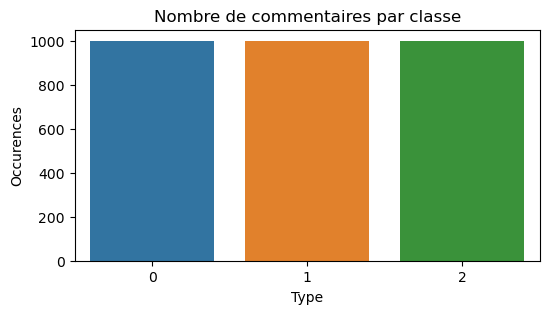

In [241]:
x = data_plot.reset_index()
#plot
plt.figure(figsize=(6,3))
ax= sns.barplot(x, x="Label", y="Review")
plt.title("Nombre de commentaires par classe")
plt.xlabel('Type')
plt.ylabel('Occurences')

plt.show()

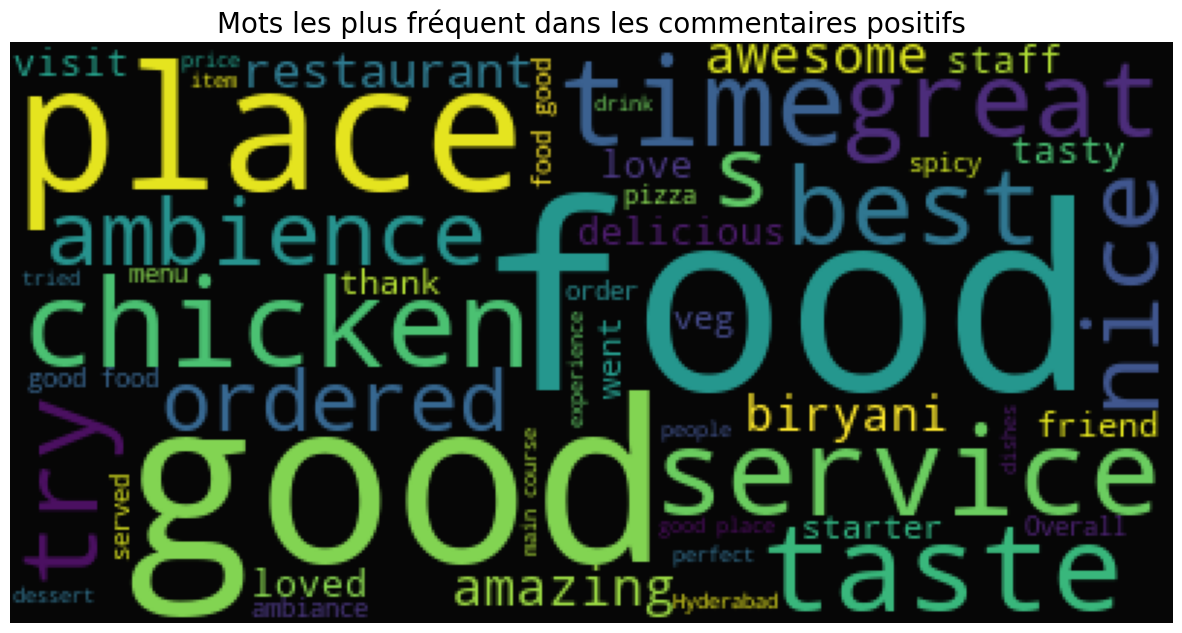

In [243]:
subnet = df_train[df_train['Label']==2]
text= subnet.Review.values
wc= WordCloud(background_color="black",max_words=50)
wc.generate(" ".join(text))
plt.figure(figsize=(15,10))
plt.axis("off")
plt.title("Mots les plus fréquent dans les commentaires positifs", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

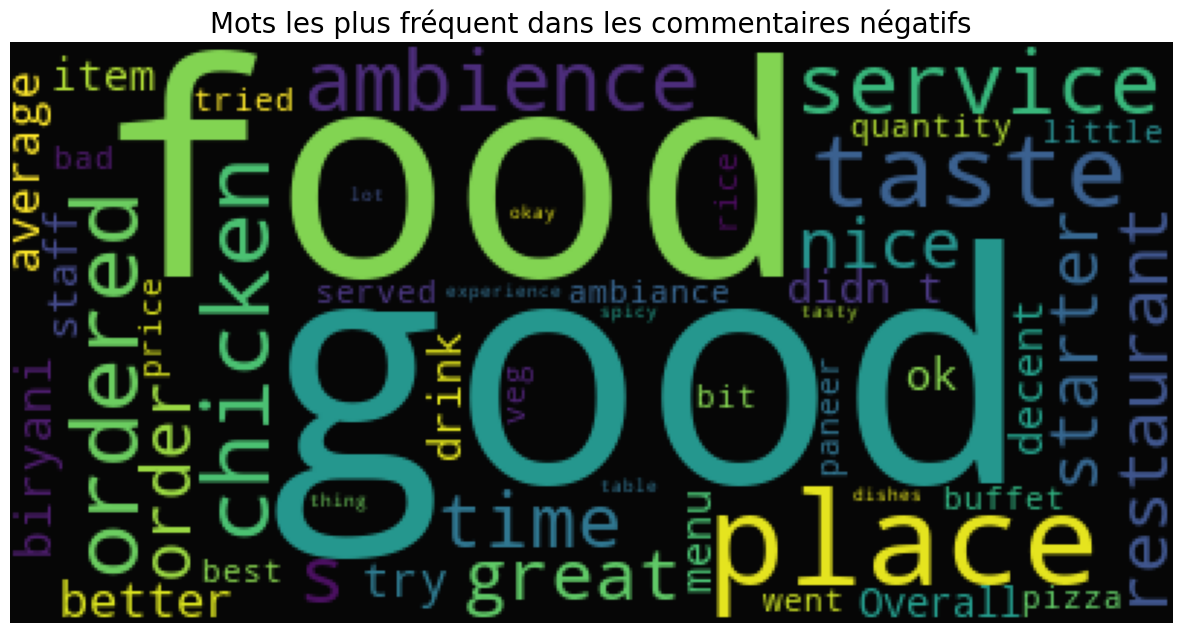

In [244]:
subnet = df_train[df_train['Label']==1]
text= subnet.Review.values
wc= WordCloud(background_color="black",max_words=50)
wc.generate(" ".join(text))
plt.figure(figsize=(15,10))
plt.axis("off")
plt.title("Mots les plus fréquent dans les commentaires neutres", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

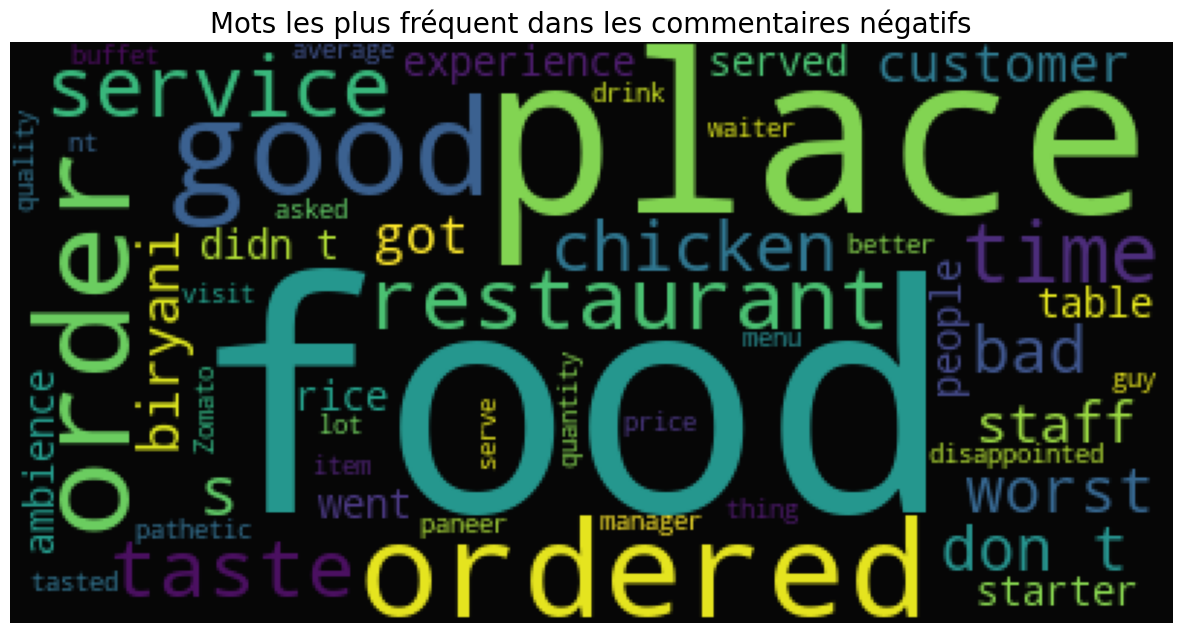

In [246]:
subnet = df_train[df_train['Label']==0]
text= subnet.Review.values
wc= WordCloud(background_color="black",max_words=50)
wc.generate(" ".join(text))
plt.figure(figsize=(15,10))
plt.axis("off")
plt.title("Mots les plus fréquent dans les commentaires négatifs", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()